In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2018/fer20131.csv
/kaggle/input/fer2018/README
/kaggle/input/fer2018/fer2013.bib
/kaggle/input/fer2018/ferSubmission.csv


In [2]:
!pip install -q torchsummary

In [3]:
'''All the required libraries for the project'''
import numpy as np
import pandas as pd
from torchvision.utils import make_grid, save_image
import torchvision.models as models
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import copy
from sklearn.metrics import roc_curve, roc_auc_score
# import tqdm
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
pd.set_option('display.max_columns', 20)

use_gpu = True
device = torch.device("cuda" if (use_gpu and torch.cuda.is_available()) else "cpu")
print(f"Using Device: {device}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using Device: cuda


In [4]:
# hyperparameters
class Hyperparameters:
    '''Hyperparameters for the project'''
    _DATA_DIR = '/kaggle/input/fer2018/fer20131.csv'
    _BATCH_SIZE = 64
    _DEBUG = True

In [5]:
# dataset class


class FacialEmotionRecognitionDataset(Dataset):
    '''This is the dataset class for the Facial Emotion Recognition Dataset
        Args:
            data_dir: path to the dataset csv file
            transform: transform to be applied to the dataset
            debug: whether to run in debug mode or not
    '''

    # constructor
    def __init__(self, data_dir, split='train', transform=None, debug=False):
        train_tfms, val_tfms = get_transformations()
        self.transform = transform
        self.split = split
        if self.transform is None:
            self.transform = train_tfms if split == 'train' else val_tfms
        self.tensor_transform = transforms.ToTensor()
        self.emotions = {
            0: 'Angry',
            1: 'Disgust',
            2: 'Fear',
            3: 'Happy',
            4: 'Sad',
            5: 'Surprise',
            6: 'Neutral'
        }
        # read the dataset
        dataset = pd.read_csv(data_dir)  # read the dataset
        if self.split == 'train':
            dataset = dataset.loc[dataset.Usage.isin(
                ['Training', 'PublicTest'])]
            dataset.reset_index(drop=True, inplace=True)
            dataset = dataset.drop('Usage', axis=1)
        elif self.split == 'test':
            dataset = dataset.loc[dataset.Usage.isin(['PrivateTest'])]
            dataset.reset_index(drop=True, inplace=True)
            dataset = dataset.drop('Usage', axis=1)
        else:
            raise ValueError(
                "Invalid split type: must be either train or test")

        if debug:
            print("-"*100)
            print(dataset.info())
            print("-"*100)
            print(dataset.head())
            print("-"*100)

#         pixels_values = []  # for storing pixel values
#         for pix in dataset.pixels:
#             values = [int(i) for i in pix.split()]
#             pixels_values.append(values)

#         pixels_values = np.array(pixels_values)
        pixels_values = [[int(i) for i in pix.split()] for pix in dataset.pixels]   # for storing pixel values 
        pixels_values = np.array(pixels_values)
        # rescaling pixel values
        pixels_values = pixels_values/255.0
        dataset.drop(columns=['pixels'], axis=1, inplace=True)
        self.pix_cols = []  # for keeping track of column names

        # add each pixel value as a column
        for i in range(pixels_values.shape[1]):
            self.pix_cols.append(f'pixel_{i}')
            dataset[f'pixel_{i}'] = pixels_values[:, i]

        if debug:
            print("-"*100)
            print("| Refined Dataset |")
            print("-"*100)
            print(dataset.head())
            print("-"*100)

        self.df = dataset

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['emotion'])
        img = np.copy(row[self.pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id

    def plot_distribution(self, path=None):
        '''This function plots the distribution of the dataset'''
        plt.figure(figsize=(10, 6))
        sns.countplot(x='emotion', data=self.df)
        plt.title(f"Emotion Distribution: {self.split.upper()} Dataset", fontsize=18)
        plt.xticks(ticks=range(0, 7), labels=[
                   self.emotions[i] for i in range(0, 7)], )
        if path:
            plt.savefig(path)
        plt.show()

# transformations


def get_transformations():
    '''
        Return transformations to be applied.
        Input:
            None
        Output:
            train_transforms: transformations to be applied on the training set
            valid_transforms: transformations to be applied on the validation or test set
    '''

    train_trans = [
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
        transforms.RandomRotation(15),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]

    val_trans = [
        transforms.ToTensor(),
    ]

    train_transforms = transforms.Compose(train_trans)
    valid_transforms = transforms.Compose(val_trans)

    return train_transforms, valid_transforms

# get dataloaders


def get_dataloaders(data_dir, val_size=0.2, batch_size=32, shuffle=True, transformations=None, debug=False):
    '''This is function to load the dataset and returns the dataloaders
        Args:
            data_dir: path to the dataset
            batch_size: batch size for the dataloader
            num_workers: number of workers for the dataloader
            shuffle: whether to shuffle the dataset or not
            debug: whether to run in debug mode or not
        Returns:
            train_loader: dataloader for the training set
            val_loader: dataloader for the validation set
            test_loader: dataloader for the test set
    '''
    train_dataset = FacialEmotionRecognitionDataset(
        data_dir=data_dir, split='train', debug=debug, transform=transformations)
    test_dataset = FacialEmotionRecognitionDataset(
        data_dir=data_dir, split='test', debug=debug, transform=transformations)
    if debug:
        train_dataset.plot_distribution()
        test_dataset.plot_distribution()

    val_len = int(val_size*len(train_dataset))
    train_ds, val_ds = random_split(
        train_dataset, [len(train_dataset)-val_len, val_len])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle)

    if debug:
        print("-"*100)
        print(f"Train Dataset: {len(train_ds)} ({len(train_loader)} batches)")
        print(f"Validation Dataset: {len(val_ds)} ({len(val_loader)} batches)")
        print(
            f"Test Dataset: {len(test_dataset)} ({len(test_loader)} batches)")
        print("-"*100)

    return train_loader, val_loader, test_loader

# show images


def show_images(dataloader, title='Images'):
    '''This function plots the images from the dataloader'''
    fig, ax = plt.figure(figsize=(16, 8)), plt.axis("off")
    for images, _ in dataloader:
        print('Images Shape:', images.shape)
        plt.imshow(make_grid(images, nrow=8).permute(
            (1, 2, 0)))  # move the channel dimension
        break

    plt.suptitle(f"{title}", y=0.92, fontsize=12)
    plt.show()

# accuracy calculation


def get_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def get_model(num_classes, device, model_name='resnet34'):
    '''This function returns the model to be used for training'''
    if model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        out_features = 512
    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=True)
        out_features = 512
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        out_features = 2048
    elif model_name == 'resnet101':
        out_features = 2048
        model = models.resnet101(pretrained=True)
    else:
        raise ValueError('Invalid Model Name: Options [resnet18, resnet34, resnet50, resnet101]]')
    # add first layer to have input channels as 1
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7,
                            stride=2, padding=3, bias=False)
    model.fc = nn.Sequential(
        nn.Linear(out_features, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, num_classes),
        nn.LogSoftmax(dim=1)
    )
    model = model.to(device)
    return model

def confusion_matrix(labels, outputs):
    labels = labels.cpu().numpy()
    predicted = torch.argmax(outputs, dim=1).cpu().numpy()
    dimensions = 7 #len(np.unique(labels))
    matrix = np.zeros((dimensions, dimensions))
    for i in range(len(labels)):
        matrix[labels[i], predicted[i]] += 1
    return matrix

def evaluate_model(model, dataloader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    dimensions = 7
    matrix = np.zeros((dimensions, dimensions))
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        acc = get_accuracy(outputs, labels)
        labels = labels.cpu().numpy()
        predicted = torch.argmax(outputs, dim=1).cpu().numpy()
        for i in range(len(labels)):
            matrix[labels[i], predicted[i]] += 1
        running_loss += loss.item()
        running_acc += acc
    
    running_loss /= len(dataloader)
    running_acc /= len(dataloader)
    return running_loss, running_acc, matrix


def train_model(model, train_loader, val_loader, device, params, debug=False):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=params['lr'],
                                                    epochs=params['num_epochs'],
                                                    steps_per_epoch=len(train_loader))

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_loss = np.inf

    for epoch in range(params['num_epochs']):
        print(f"|--------- Epoch: {epoch+1:>{len(str(params['num_epochs']))}}/{params['num_epochs']} " + "-"*110)
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        curr_len = 0
        batch_id = 0
        for images, labels in tqdm(train_loader, ascii=True, desc=f"Epoch: {epoch+1:>{len(str(params['num_epochs']))}}/{params['num_epochs']}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            acc = get_accuracy(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * images.shape[0]
            running_acc += acc
            curr_len += images.shape[0]
            batch_id += 1
            if debug and batch_id % params['print_every'] == 0:
                curr_loss = running_loss/curr_len
                curr_acc = running_acc/batch_id
                print('\t\t'+'-'*70)
                print(
                    f"\t\t| Batch: {batch_id:>{len(str(len(train_loader)))}}/{len(train_loader)} | Training Loss: {curr_loss:.4f} | Training Accuracy: {curr_acc:.4f} |")
                print('\t\t'+'-'*70)

        running_loss /= len(train_loader.dataset)
        running_acc /= len(train_loader)
        train_losses.append(running_loss)
        train_accuracies.append(running_acc)
        val_loss, val_acc, cm = evaluate_model(
            model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())

        print('-'*120)
        print(f"Epoch: {epoch+1:>{len(str(params['num_epochs']))}}/{params['num_epochs']} | Training Loss: {running_loss:.4f} | Training Accuracy: {running_acc:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
        print('-'*120)
        print("-"*130 + '-|')

    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), params['save_path'])
    return model, (train_losses, train_accuracies, val_losses, val_accuracies)


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32298 entries, 0 to 32297
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  32298 non-null  int64 
 1   pixels   32298 non-null  object
dtypes: int64(1), object(1)
memory usage: 504.8+ KB
None
----------------------------------------------------------------------------------------------------
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
----------------------------------------------------------------------------------------------------
------------

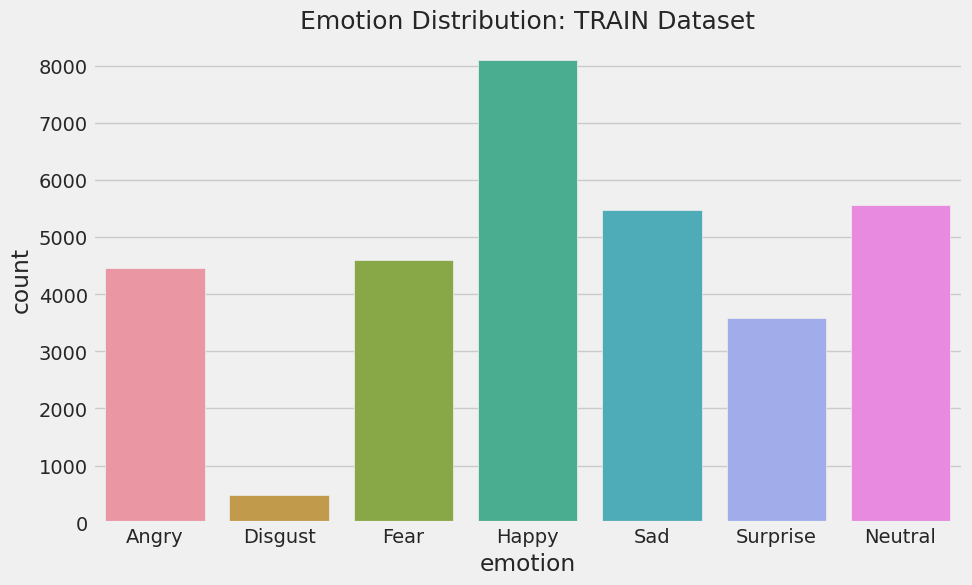

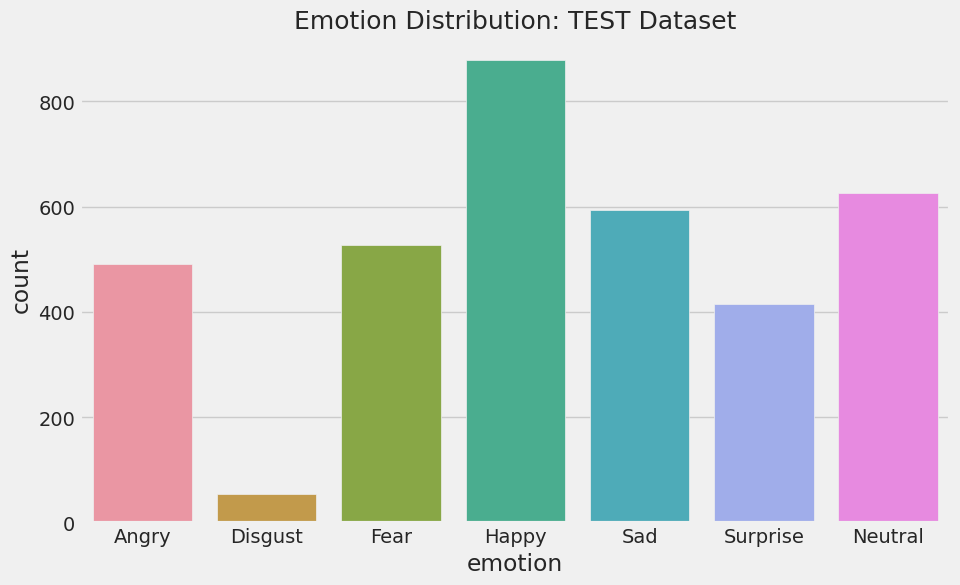

----------------------------------------------------------------------------------------------------
Train Dataset: 25839 (404 batches)
Validation Dataset: 6459 (101 batches)
Test Dataset: 3589 (57 batches)
----------------------------------------------------------------------------------------------------


In [6]:
train_loader, val_loader, test_loader = get_dataloaders(data_dir=Hyperparameters._DATA_DIR, batch_size= Hyperparameters._BATCH_SIZE, debug=Hyperparameters._DEBUG)

Images Shape: torch.Size([64, 1, 48, 48])


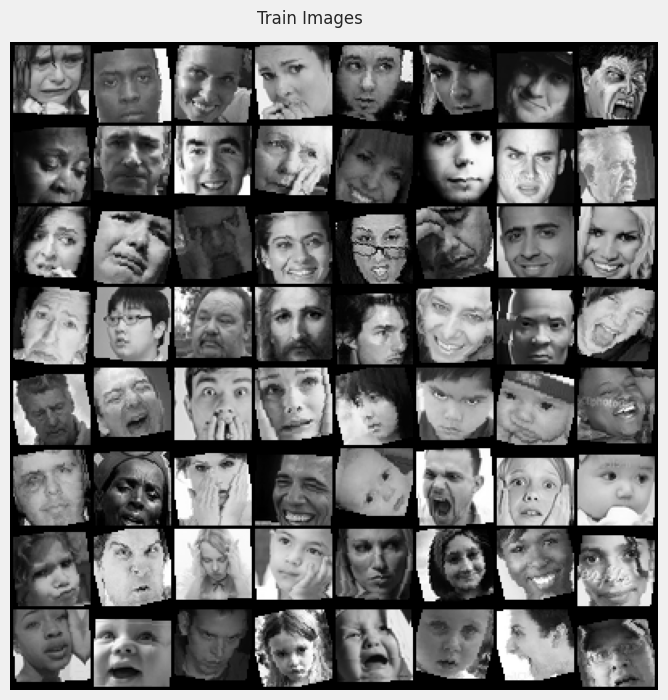

In [7]:
show_images(train_loader, 'Train Images')

Images Shape: torch.Size([64, 1, 48, 48])


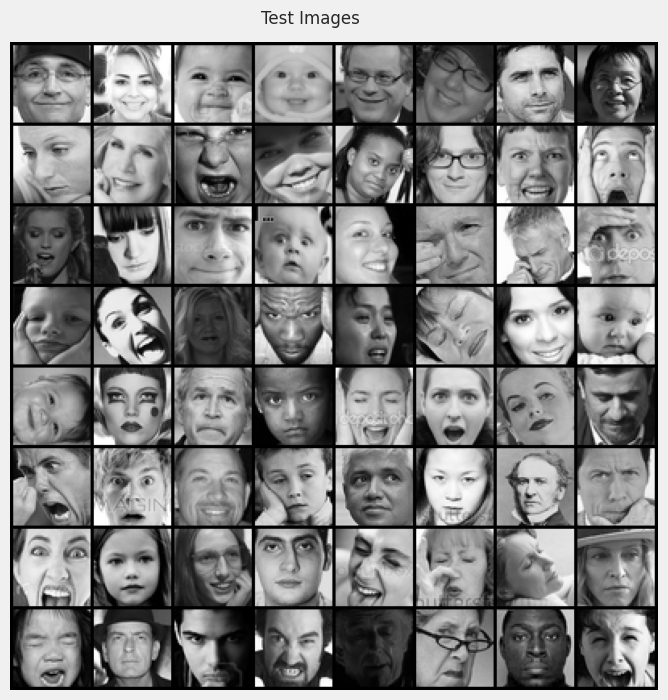

In [8]:
show_images(test_loader, 'Test Images')

In [9]:
params = {
    'batch_size': 64,
    'shuffle': True,
    'num_workers': 1,
    'lr': 3e-3,
    'weight_decay': 1e-5,
    'num_epochs': 32,
    'num_classes': 7,
    'print_every': 100,
    'save_path': 'model.pt'
}

model = get_model(params['num_classes'], device, model_name='resnet18')

trained_model, history = train_model(model, train_loader, val_loader, device= device, params= params, debug= Hyperparameters._DEBUG)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


|--------- Epoch:  1/32 --------------------------------------------------------------------------------------------------------------


Epoch:  1/32:  25%|##4       | 100/404 [00:46<02:02,  2.47it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.8170 | Training Accuracy: 0.2491 |
		----------------------------------------------------------------------


Epoch:  1/32:  50%|####9     | 200/404 [01:27<01:21,  2.51it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.7740 | Training Accuracy: 0.2746 |
		----------------------------------------------------------------------


Epoch:  1/32:  74%|#######4  | 300/404 [02:07<00:42,  2.47it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.7353 | Training Accuracy: 0.3009 |
		----------------------------------------------------------------------


Epoch:  1/32:  99%|#########9| 400/404 [02:48<00:01,  2.24it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.7076 | Training Accuracy: 0.3166 |
		----------------------------------------------------------------------


Epoch:  1/32: 100%|##########| 404/404 [02:49<00:00,  2.38it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  1/32 | Training Loss: 1.7065 | Training Accuracy: 0.3173 | Validation Loss: 1.5850 | Validation Accuracy: 0.3812
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  2/32 --------------------------------------------------------------------------------------------------------------


Epoch:  2/32:  25%|##4       | 100/404 [00:41<01:59,  2.54it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.5659 | Training Accuracy: 0.3908 |
		----------------------------------------------------------------------


Epoch:  2/32:  50%|####9     | 200/404 [01:21<01:21,  2.49it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.5562 | Training Accuracy: 0.3934 |
		----------------------------------------------------------------------


Epoch:  2/32:  74%|#######4  | 300/404 [02:02<00:40,  2.60it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.5393 | Training Accuracy: 0.4063 |
		----------------------------------------------------------------------


Epoch:  2/32:  99%|#########9| 400/404 [02:41<00:01,  2.57it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.5267 | Training Accuracy: 0.4140 |
		----------------------------------------------------------------------


Epoch:  2/32: 100%|##########| 404/404 [02:43<00:00,  2.48it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  2/32 | Training Loss: 1.5265 | Training Accuracy: 0.4138 | Validation Loss: 1.5414 | Validation Accuracy: 0.4107
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  3/32 --------------------------------------------------------------------------------------------------------------


Epoch:  3/32:  25%|##4       | 100/404 [00:40<02:31,  2.00it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.4550 | Training Accuracy: 0.4434 |
		----------------------------------------------------------------------


Epoch:  3/32:  50%|####9     | 200/404 [01:20<01:20,  2.54it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.4502 | Training Accuracy: 0.4484 |
		----------------------------------------------------------------------


Epoch:  3/32:  74%|#######4  | 300/404 [01:59<00:40,  2.59it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.4379 | Training Accuracy: 0.4547 |
		----------------------------------------------------------------------


Epoch:  3/32:  99%|#########9| 400/404 [02:40<00:01,  2.48it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.4322 | Training Accuracy: 0.4582 |
		----------------------------------------------------------------------


Epoch:  3/32: 100%|##########| 404/404 [02:41<00:00,  2.50it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  3/32 | Training Loss: 1.4329 | Training Accuracy: 0.4577 | Validation Loss: 1.7344 | Validation Accuracy: 0.3406
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  4/32 --------------------------------------------------------------------------------------------------------------


Epoch:  4/32:  25%|##4       | 100/404 [00:39<01:55,  2.64it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.3900 | Training Accuracy: 0.4803 |
		----------------------------------------------------------------------


Epoch:  4/32:  50%|####9     | 200/404 [01:18<01:17,  2.62it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.3890 | Training Accuracy: 0.4754 |
		----------------------------------------------------------------------


Epoch:  4/32:  74%|#######4  | 300/404 [01:58<00:39,  2.63it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.3926 | Training Accuracy: 0.4735 |
		----------------------------------------------------------------------


Epoch:  4/32:  99%|#########9| 400/404 [02:38<00:01,  2.49it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.3918 | Training Accuracy: 0.4741 |
		----------------------------------------------------------------------


Epoch:  4/32: 100%|##########| 404/404 [02:39<00:00,  2.53it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  4/32 | Training Loss: 1.3922 | Training Accuracy: 0.4740 | Validation Loss: 1.4354 | Validation Accuracy: 0.4560
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  5/32 --------------------------------------------------------------------------------------------------------------


Epoch:  5/32:  25%|##4       | 100/404 [00:39<01:57,  2.58it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.3745 | Training Accuracy: 0.4870 |
		----------------------------------------------------------------------


Epoch:  5/32:  50%|####9     | 200/404 [01:19<01:17,  2.64it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.3689 | Training Accuracy: 0.4860 |
		----------------------------------------------------------------------


Epoch:  5/32:  74%|#######4  | 300/404 [01:59<00:42,  2.45it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.3755 | Training Accuracy: 0.4812 |
		----------------------------------------------------------------------


Epoch:  5/32:  99%|#########9| 400/404 [02:38<00:01,  2.62it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.3714 | Training Accuracy: 0.4827 |
		----------------------------------------------------------------------


Epoch:  5/32: 100%|##########| 404/404 [02:39<00:00,  2.53it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  5/32 | Training Loss: 1.3709 | Training Accuracy: 0.4829 | Validation Loss: 1.5604 | Validation Accuracy: 0.4123
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  6/32 --------------------------------------------------------------------------------------------------------------


Epoch:  6/32:  25%|##4       | 100/404 [00:40<01:56,  2.61it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.3783 | Training Accuracy: 0.4859 |
		----------------------------------------------------------------------


Epoch:  6/32:  50%|####9     | 200/404 [01:20<01:19,  2.58it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.3680 | Training Accuracy: 0.4894 |
		----------------------------------------------------------------------


Epoch:  6/32:  74%|#######4  | 300/404 [02:00<00:40,  2.59it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.3614 | Training Accuracy: 0.4914 |
		----------------------------------------------------------------------


Epoch:  6/32:  99%|#########9| 400/404 [02:40<00:01,  2.62it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.3575 | Training Accuracy: 0.4937 |
		----------------------------------------------------------------------


Epoch:  6/32: 100%|##########| 404/404 [02:41<00:00,  2.50it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  6/32 | Training Loss: 1.3582 | Training Accuracy: 0.4936 | Validation Loss: 1.4805 | Validation Accuracy: 0.4369
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  7/32 --------------------------------------------------------------------------------------------------------------


Epoch:  7/32:  25%|##4       | 100/404 [00:41<01:58,  2.57it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.3376 | Training Accuracy: 0.4928 |
		----------------------------------------------------------------------


Epoch:  7/32:  50%|####9     | 200/404 [01:20<01:18,  2.59it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.3319 | Training Accuracy: 0.5032 |
		----------------------------------------------------------------------


Epoch:  7/32:  74%|#######4  | 300/404 [02:01<00:40,  2.58it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.3302 | Training Accuracy: 0.5043 |
		----------------------------------------------------------------------


Epoch:  7/32:  99%|#########9| 400/404 [02:41<00:01,  2.34it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.3258 | Training Accuracy: 0.5057 |
		----------------------------------------------------------------------


Epoch:  7/32: 100%|##########| 404/404 [02:43<00:00,  2.48it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  7/32 | Training Loss: 1.3260 | Training Accuracy: 0.5060 | Validation Loss: 1.4597 | Validation Accuracy: 0.4330
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  8/32 --------------------------------------------------------------------------------------------------------------


Epoch:  8/32:  25%|##4       | 100/404 [00:40<01:56,  2.60it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.3203 | Training Accuracy: 0.5070 |
		----------------------------------------------------------------------


Epoch:  8/32:  50%|####9     | 200/404 [01:20<01:19,  2.55it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.3190 | Training Accuracy: 0.5074 |
		----------------------------------------------------------------------


Epoch:  8/32:  74%|#######4  | 300/404 [02:01<00:43,  2.38it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.3240 | Training Accuracy: 0.5068 |
		----------------------------------------------------------------------


Epoch:  8/32:  99%|#########9| 400/404 [02:42<00:01,  2.54it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.3181 | Training Accuracy: 0.5104 |
		----------------------------------------------------------------------


Epoch:  8/32: 100%|##########| 404/404 [02:44<00:00,  2.46it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  8/32 | Training Loss: 1.3181 | Training Accuracy: 0.5106 | Validation Loss: 1.4454 | Validation Accuracy: 0.4607
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch:  9/32 --------------------------------------------------------------------------------------------------------------


Epoch:  9/32:  25%|##4       | 100/404 [00:41<02:12,  2.29it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.2753 | Training Accuracy: 0.5308 |
		----------------------------------------------------------------------


Epoch:  9/32:  50%|####9     | 200/404 [01:22<01:21,  2.50it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.2833 | Training Accuracy: 0.5180 |
		----------------------------------------------------------------------


Epoch:  9/32:  74%|#######4  | 300/404 [02:02<00:41,  2.49it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.2788 | Training Accuracy: 0.5208 |
		----------------------------------------------------------------------


Epoch:  9/32:  99%|#########9| 400/404 [02:43<00:01,  2.51it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.2780 | Training Accuracy: 0.5194 |
		----------------------------------------------------------------------


Epoch:  9/32: 100%|##########| 404/404 [02:45<00:00,  2.44it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch:  9/32 | Training Loss: 1.2770 | Training Accuracy: 0.5198 | Validation Loss: 1.4712 | Validation Accuracy: 0.4565
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 10/32 --------------------------------------------------------------------------------------------------------------


Epoch: 10/32:  25%|##4       | 100/404 [00:40<01:58,  2.57it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.2672 | Training Accuracy: 0.5231 |
		----------------------------------------------------------------------


Epoch: 10/32:  50%|####9     | 200/404 [01:21<01:20,  2.54it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.2606 | Training Accuracy: 0.5234 |
		----------------------------------------------------------------------


Epoch: 10/32:  74%|#######4  | 300/404 [02:03<00:47,  2.18it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.2663 | Training Accuracy: 0.5237 |
		----------------------------------------------------------------------


Epoch: 10/32:  99%|#########9| 400/404 [02:44<00:01,  2.34it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.2668 | Training Accuracy: 0.5248 |
		----------------------------------------------------------------------


Epoch: 10/32: 100%|##########| 404/404 [02:46<00:00,  2.43it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 10/32 | Training Loss: 1.2670 | Training Accuracy: 0.5245 | Validation Loss: 1.3193 | Validation Accuracy: 0.5091
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 11/32 --------------------------------------------------------------------------------------------------------------


Epoch: 11/32:  25%|##4       | 100/404 [00:41<02:17,  2.21it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.2301 | Training Accuracy: 0.5469 |
		----------------------------------------------------------------------


Epoch: 11/32:  50%|####9     | 200/404 [01:21<01:20,  2.54it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.2242 | Training Accuracy: 0.5441 |
		----------------------------------------------------------------------


Epoch: 11/32:  74%|#######4  | 300/404 [02:02<00:40,  2.58it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.2379 | Training Accuracy: 0.5366 |
		----------------------------------------------------------------------


Epoch: 11/32:  99%|#########9| 400/404 [02:42<00:01,  2.54it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.2321 | Training Accuracy: 0.5404 |
		----------------------------------------------------------------------


Epoch: 11/32: 100%|##########| 404/404 [02:44<00:00,  2.46it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 11/32 | Training Loss: 1.2324 | Training Accuracy: 0.5400 | Validation Loss: 1.2834 | Validation Accuracy: 0.5213
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 12/32 --------------------------------------------------------------------------------------------------------------


Epoch: 12/32:  25%|##4       | 100/404 [00:40<02:01,  2.51it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.2697 | Training Accuracy: 0.5286 |
		----------------------------------------------------------------------


Epoch: 12/32:  50%|####9     | 200/404 [01:21<01:20,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.2635 | Training Accuracy: 0.5319 |
		----------------------------------------------------------------------


Epoch: 12/32:  74%|#######4  | 300/404 [02:02<00:44,  2.35it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.2631 | Training Accuracy: 0.5291 |
		----------------------------------------------------------------------


Epoch: 12/32:  99%|#########9| 400/404 [02:42<00:01,  2.52it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.2445 | Training Accuracy: 0.5355 |
		----------------------------------------------------------------------


Epoch: 12/32: 100%|##########| 404/404 [02:44<00:00,  2.46it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 12/32 | Training Loss: 1.2446 | Training Accuracy: 0.5349 | Validation Loss: 1.3528 | Validation Accuracy: 0.4908
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 13/32 --------------------------------------------------------------------------------------------------------------


Epoch: 13/32:  25%|##4       | 100/404 [00:40<02:00,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.2301 | Training Accuracy: 0.5355 |
		----------------------------------------------------------------------


Epoch: 13/32:  50%|####9     | 200/404 [01:22<01:20,  2.54it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.2120 | Training Accuracy: 0.5446 |
		----------------------------------------------------------------------


Epoch: 13/32:  74%|#######4  | 300/404 [02:02<00:42,  2.45it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.2215 | Training Accuracy: 0.5387 |
		----------------------------------------------------------------------


Epoch: 13/32:  99%|#########9| 400/404 [02:43<00:01,  2.52it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.2275 | Training Accuracy: 0.5389 |
		----------------------------------------------------------------------


Epoch: 13/32: 100%|##########| 404/404 [02:45<00:00,  2.44it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 13/32 | Training Loss: 1.2277 | Training Accuracy: 0.5388 | Validation Loss: 1.2648 | Validation Accuracy: 0.5191
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 14/32 --------------------------------------------------------------------------------------------------------------


Epoch: 14/32:  25%|##4       | 100/404 [00:41<02:01,  2.51it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.2603 | Training Accuracy: 0.5272 |
		----------------------------------------------------------------------


Epoch: 14/32:  50%|####9     | 200/404 [01:23<01:24,  2.42it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.2410 | Training Accuracy: 0.5334 |
		----------------------------------------------------------------------


Epoch: 14/32:  74%|#######4  | 300/404 [02:05<00:51,  2.01it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.2183 | Training Accuracy: 0.5439 |
		----------------------------------------------------------------------


Epoch: 14/32:  99%|#########9| 400/404 [02:46<00:01,  2.47it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.2121 | Training Accuracy: 0.5457 |
		----------------------------------------------------------------------


Epoch: 14/32: 100%|##########| 404/404 [02:48<00:00,  2.40it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 14/32 | Training Loss: 1.2116 | Training Accuracy: 0.5458 | Validation Loss: 1.3084 | Validation Accuracy: 0.4902
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 15/32 --------------------------------------------------------------------------------------------------------------


Epoch: 15/32:  25%|##4       | 100/404 [00:40<02:01,  2.51it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.1797 | Training Accuracy: 0.5537 |
		----------------------------------------------------------------------


Epoch: 15/32:  50%|####9     | 200/404 [01:22<01:21,  2.52it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.1692 | Training Accuracy: 0.5577 |
		----------------------------------------------------------------------


Epoch: 15/32:  74%|#######4  | 300/404 [02:02<00:40,  2.56it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.1752 | Training Accuracy: 0.5577 |
		----------------------------------------------------------------------


Epoch: 15/32:  99%|#########9| 400/404 [02:43<00:01,  2.55it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.1713 | Training Accuracy: 0.5582 |
		----------------------------------------------------------------------


Epoch: 15/32: 100%|##########| 404/404 [02:44<00:00,  2.45it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 15/32 | Training Loss: 1.1707 | Training Accuracy: 0.5585 | Validation Loss: 1.2538 | Validation Accuracy: 0.5265
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 16/32 --------------------------------------------------------------------------------------------------------------


Epoch: 16/32:  25%|##4       | 100/404 [00:41<02:03,  2.47it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.1936 | Training Accuracy: 0.5458 |
		----------------------------------------------------------------------


Epoch: 16/32:  50%|####9     | 200/404 [01:22<01:19,  2.55it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.1871 | Training Accuracy: 0.5546 |
		----------------------------------------------------------------------


Epoch: 16/32:  74%|#######4  | 300/404 [02:04<00:57,  1.82it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.1718 | Training Accuracy: 0.5619 |
		----------------------------------------------------------------------


Epoch: 16/32:  99%|#########9| 400/404 [02:45<00:01,  2.47it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.1666 | Training Accuracy: 0.5653 |
		----------------------------------------------------------------------


Epoch: 16/32: 100%|##########| 404/404 [02:46<00:00,  2.42it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 16/32 | Training Loss: 1.1670 | Training Accuracy: 0.5647 | Validation Loss: 1.3122 | Validation Accuracy: 0.5004
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 17/32 --------------------------------------------------------------------------------------------------------------


Epoch: 17/32:  25%|##4       | 100/404 [00:40<01:59,  2.55it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.1150 | Training Accuracy: 0.5867 |
		----------------------------------------------------------------------


Epoch: 17/32:  50%|####9     | 200/404 [01:22<01:21,  2.50it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.1232 | Training Accuracy: 0.5817 |
		----------------------------------------------------------------------


Epoch: 17/32:  74%|#######4  | 300/404 [02:03<00:41,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.1179 | Training Accuracy: 0.5833 |
		----------------------------------------------------------------------


Epoch: 17/32:  99%|#########9| 400/404 [02:44<00:01,  2.52it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.1158 | Training Accuracy: 0.5850 |
		----------------------------------------------------------------------


Epoch: 17/32: 100%|##########| 404/404 [02:45<00:00,  2.44it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 17/32 | Training Loss: 1.1163 | Training Accuracy: 0.5844 | Validation Loss: 1.2348 | Validation Accuracy: 0.5346
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 18/32 --------------------------------------------------------------------------------------------------------------


Epoch: 18/32:  25%|##4       | 100/404 [00:41<02:04,  2.45it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.0835 | Training Accuracy: 0.5962 |
		----------------------------------------------------------------------


Epoch: 18/32:  50%|####9     | 200/404 [01:21<01:19,  2.57it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.1721 | Training Accuracy: 0.5638 |
		----------------------------------------------------------------------


Epoch: 18/32:  74%|#######4  | 300/404 [02:01<00:41,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.1759 | Training Accuracy: 0.5585 |
		----------------------------------------------------------------------


Epoch: 18/32:  99%|#########9| 400/404 [02:43<00:01,  2.56it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.1685 | Training Accuracy: 0.5595 |
		----------------------------------------------------------------------


Epoch: 18/32: 100%|##########| 404/404 [02:44<00:00,  2.45it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 18/32 | Training Loss: 1.1685 | Training Accuracy: 0.5597 | Validation Loss: 1.2692 | Validation Accuracy: 0.5197
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 19/32 --------------------------------------------------------------------------------------------------------------


Epoch: 19/32:  25%|##4       | 100/404 [00:41<02:02,  2.49it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.1408 | Training Accuracy: 0.5644 |
		----------------------------------------------------------------------


Epoch: 19/32:  50%|####9     | 200/404 [01:23<01:22,  2.49it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.1481 | Training Accuracy: 0.5695 |
		----------------------------------------------------------------------


Epoch: 19/32:  74%|#######4  | 300/404 [02:04<00:48,  2.16it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.1534 | Training Accuracy: 0.5671 |
		----------------------------------------------------------------------


Epoch: 19/32:  99%|#########9| 400/404 [02:45<00:01,  2.38it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.1631 | Training Accuracy: 0.5608 |
		----------------------------------------------------------------------


Epoch: 19/32: 100%|##########| 404/404 [02:47<00:00,  2.42it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 19/32 | Training Loss: 1.1632 | Training Accuracy: 0.5611 | Validation Loss: 1.2503 | Validation Accuracy: 0.5233
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 20/32 --------------------------------------------------------------------------------------------------------------


Epoch: 20/32:  25%|##4       | 100/404 [00:42<02:04,  2.44it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.1694 | Training Accuracy: 0.5631 |
		----------------------------------------------------------------------


Epoch: 20/32:  50%|####9     | 200/404 [01:24<01:23,  2.46it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.1569 | Training Accuracy: 0.5632 |
		----------------------------------------------------------------------


Epoch: 20/32:  74%|#######4  | 300/404 [02:06<00:51,  2.01it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.1509 | Training Accuracy: 0.5641 |
		----------------------------------------------------------------------


Epoch: 20/32:  99%|#########9| 400/404 [02:47<00:01,  2.40it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.1443 | Training Accuracy: 0.5666 |
		----------------------------------------------------------------------


Epoch: 20/32: 100%|##########| 404/404 [02:49<00:00,  2.38it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 20/32 | Training Loss: 1.1424 | Training Accuracy: 0.5670 | Validation Loss: 1.2010 | Validation Accuracy: 0.5390
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 21/32 --------------------------------------------------------------------------------------------------------------


Epoch: 21/32:  25%|##4       | 100/404 [00:40<01:57,  2.58it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.1080 | Training Accuracy: 0.5805 |
		----------------------------------------------------------------------


Epoch: 21/32:  50%|####9     | 200/404 [01:21<01:21,  2.51it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.1209 | Training Accuracy: 0.5755 |
		----------------------------------------------------------------------


Epoch: 21/32:  74%|#######4  | 300/404 [02:02<00:41,  2.49it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.1263 | Training Accuracy: 0.5753 |
		----------------------------------------------------------------------


Epoch: 21/32:  99%|#########9| 400/404 [02:44<00:01,  2.44it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.1228 | Training Accuracy: 0.5771 |
		----------------------------------------------------------------------


Epoch: 21/32: 100%|##########| 404/404 [02:45<00:00,  2.44it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 21/32 | Training Loss: 1.1232 | Training Accuracy: 0.5773 | Validation Loss: 1.1826 | Validation Accuracy: 0.5561
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 22/32 --------------------------------------------------------------------------------------------------------------


Epoch: 22/32:  25%|##4       | 100/404 [00:41<02:04,  2.43it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.0594 | Training Accuracy: 0.6027 |
		----------------------------------------------------------------------


Epoch: 22/32:  50%|####9     | 200/404 [01:23<01:26,  2.37it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.0687 | Training Accuracy: 0.6004 |
		----------------------------------------------------------------------


Epoch: 22/32:  74%|#######4  | 300/404 [02:06<00:51,  2.04it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.0634 | Training Accuracy: 0.6021 |
		----------------------------------------------------------------------


Epoch: 22/32:  99%|#########9| 400/404 [02:47<00:01,  2.44it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.0603 | Training Accuracy: 0.6030 |
		----------------------------------------------------------------------


Epoch: 22/32: 100%|##########| 404/404 [02:49<00:00,  2.39it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 22/32 | Training Loss: 1.0599 | Training Accuracy: 0.6030 | Validation Loss: 1.1270 | Validation Accuracy: 0.5749
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 23/32 --------------------------------------------------------------------------------------------------------------


Epoch: 23/32:  25%|##4       | 100/404 [00:41<02:08,  2.37it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.0197 | Training Accuracy: 0.6167 |
		----------------------------------------------------------------------


Epoch: 23/32:  50%|####9     | 200/404 [01:22<01:22,  2.47it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.0263 | Training Accuracy: 0.6124 |
		----------------------------------------------------------------------


Epoch: 23/32:  74%|#######4  | 300/404 [02:03<00:40,  2.58it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.0319 | Training Accuracy: 0.6107 |
		----------------------------------------------------------------------


Epoch: 23/32:  99%|#########9| 400/404 [02:44<00:01,  2.59it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.0327 | Training Accuracy: 0.6107 |
		----------------------------------------------------------------------


Epoch: 23/32: 100%|##########| 404/404 [02:46<00:00,  2.42it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 23/32 | Training Loss: 1.0321 | Training Accuracy: 0.6108 | Validation Loss: 1.1239 | Validation Accuracy: 0.5793
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 24/32 --------------------------------------------------------------------------------------------------------------


Epoch: 24/32:  25%|##4       | 100/404 [00:40<02:08,  2.37it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 1.0128 | Training Accuracy: 0.6177 |
		----------------------------------------------------------------------


Epoch: 24/32:  50%|####9     | 200/404 [01:21<01:22,  2.48it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.0072 | Training Accuracy: 0.6222 |
		----------------------------------------------------------------------


Epoch: 24/32:  74%|#######4  | 300/404 [02:03<00:41,  2.48it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 1.0139 | Training Accuracy: 0.6209 |
		----------------------------------------------------------------------


Epoch: 24/32:  99%|#########9| 400/404 [02:44<00:01,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 1.0125 | Training Accuracy: 0.6205 |
		----------------------------------------------------------------------


Epoch: 24/32: 100%|##########| 404/404 [02:46<00:00,  2.43it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 24/32 | Training Loss: 1.0121 | Training Accuracy: 0.6207 | Validation Loss: 1.1097 | Validation Accuracy: 0.5897
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 25/32 --------------------------------------------------------------------------------------------------------------


Epoch: 25/32:  25%|##4       | 100/404 [00:41<02:05,  2.42it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9979 | Training Accuracy: 0.6242 |
		----------------------------------------------------------------------


Epoch: 25/32:  50%|####9     | 200/404 [01:23<01:19,  2.56it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 1.0046 | Training Accuracy: 0.6218 |
		----------------------------------------------------------------------


Epoch: 25/32:  74%|#######4  | 300/404 [02:04<00:41,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9943 | Training Accuracy: 0.6238 |
		----------------------------------------------------------------------


Epoch: 25/32:  99%|#########9| 400/404 [02:46<00:02,  1.82it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9916 | Training Accuracy: 0.6251 |
		----------------------------------------------------------------------


Epoch: 25/32: 100%|##########| 404/404 [02:47<00:00,  2.41it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 25/32 | Training Loss: 0.9911 | Training Accuracy: 0.6250 | Validation Loss: 1.0993 | Validation Accuracy: 0.5887
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 26/32 --------------------------------------------------------------------------------------------------------------


Epoch: 26/32:  25%|##4       | 100/404 [00:41<01:58,  2.56it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9924 | Training Accuracy: 0.6278 |
		----------------------------------------------------------------------


Epoch: 26/32:  50%|####9     | 200/404 [01:21<01:19,  2.56it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 0.9749 | Training Accuracy: 0.6325 |
		----------------------------------------------------------------------


Epoch: 26/32:  74%|#######4  | 300/404 [02:03<00:43,  2.42it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9708 | Training Accuracy: 0.6317 |
		----------------------------------------------------------------------


Epoch: 26/32:  99%|#########9| 400/404 [02:44<00:01,  2.55it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9712 | Training Accuracy: 0.6328 |
		----------------------------------------------------------------------


Epoch: 26/32: 100%|##########| 404/404 [02:45<00:00,  2.44it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 26/32 | Training Loss: 0.9708 | Training Accuracy: 0.6331 | Validation Loss: 1.0858 | Validation Accuracy: 0.5994
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 27/32 --------------------------------------------------------------------------------------------------------------


Epoch: 27/32:  25%|##4       | 100/404 [00:41<02:51,  1.78it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9588 | Training Accuracy: 0.6406 |
		----------------------------------------------------------------------


Epoch: 27/32:  50%|####9     | 200/404 [01:21<01:18,  2.60it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 0.9596 | Training Accuracy: 0.6413 |
		----------------------------------------------------------------------


Epoch: 27/32:  74%|#######4  | 300/404 [02:01<00:41,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9596 | Training Accuracy: 0.6419 |
		----------------------------------------------------------------------


Epoch: 27/32:  99%|#########9| 400/404 [02:41<00:01,  2.46it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9582 | Training Accuracy: 0.6411 |
		----------------------------------------------------------------------


Epoch: 27/32: 100%|##########| 404/404 [02:43<00:00,  2.47it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 27/32 | Training Loss: 0.9578 | Training Accuracy: 0.6413 | Validation Loss: 1.0789 | Validation Accuracy: 0.6014
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 28/32 --------------------------------------------------------------------------------------------------------------


Epoch: 28/32:  25%|##4       | 100/404 [00:41<02:00,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9445 | Training Accuracy: 0.6438 |
		----------------------------------------------------------------------


Epoch: 28/32:  50%|####9     | 200/404 [01:21<01:21,  2.49it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 0.9422 | Training Accuracy: 0.6459 |
		----------------------------------------------------------------------


Epoch: 28/32:  74%|#######4  | 300/404 [02:01<00:39,  2.61it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9431 | Training Accuracy: 0.6449 |
		----------------------------------------------------------------------


Epoch: 28/32:  99%|#########9| 400/404 [02:42<00:01,  2.53it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9417 | Training Accuracy: 0.6466 |
		----------------------------------------------------------------------


Epoch: 28/32: 100%|##########| 404/404 [02:44<00:00,  2.46it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 28/32 | Training Loss: 0.9420 | Training Accuracy: 0.6465 | Validation Loss: 1.0796 | Validation Accuracy: 0.5934
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 29/32 --------------------------------------------------------------------------------------------------------------


Epoch: 29/32:  25%|##4       | 100/404 [00:40<01:58,  2.56it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9501 | Training Accuracy: 0.6428 |
		----------------------------------------------------------------------


Epoch: 29/32:  50%|####9     | 200/404 [01:21<01:34,  2.15it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 0.9249 | Training Accuracy: 0.6484 |
		----------------------------------------------------------------------


Epoch: 29/32:  74%|#######4  | 300/404 [02:02<00:41,  2.51it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9290 | Training Accuracy: 0.6481 |
		----------------------------------------------------------------------


Epoch: 29/32:  99%|#########9| 400/404 [02:42<00:01,  2.57it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9268 | Training Accuracy: 0.6497 |
		----------------------------------------------------------------------


Epoch: 29/32: 100%|##########| 404/404 [02:44<00:00,  2.46it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 29/32 | Training Loss: 0.9262 | Training Accuracy: 0.6499 | Validation Loss: 1.0642 | Validation Accuracy: 0.6081
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 30/32 --------------------------------------------------------------------------------------------------------------


Epoch: 30/32:  25%|##4       | 100/404 [00:41<02:04,  2.45it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9333 | Training Accuracy: 0.6514 |
		----------------------------------------------------------------------


Epoch: 30/32:  50%|####9     | 200/404 [01:22<01:20,  2.55it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 0.9180 | Training Accuracy: 0.6574 |
		----------------------------------------------------------------------


Epoch: 30/32:  74%|#######4  | 300/404 [02:03<00:41,  2.52it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9208 | Training Accuracy: 0.6549 |
		----------------------------------------------------------------------


Epoch: 30/32:  99%|#########9| 400/404 [02:45<00:01,  2.39it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9187 | Training Accuracy: 0.6559 |
		----------------------------------------------------------------------


Epoch: 30/32: 100%|##########| 404/404 [02:46<00:00,  2.42it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 30/32 | Training Loss: 0.9187 | Training Accuracy: 0.6551 | Validation Loss: 1.0494 | Validation Accuracy: 0.6108
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 31/32 --------------------------------------------------------------------------------------------------------------


Epoch: 31/32:  25%|##4       | 100/404 [00:41<02:09,  2.35it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9236 | Training Accuracy: 0.6484 |
		----------------------------------------------------------------------


Epoch: 31/32:  50%|####9     | 200/404 [01:22<01:42,  2.00it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 0.9175 | Training Accuracy: 0.6542 |
		----------------------------------------------------------------------


Epoch: 31/32:  74%|#######4  | 300/404 [02:04<00:41,  2.50it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9133 | Training Accuracy: 0.6548 |
		----------------------------------------------------------------------


Epoch: 31/32:  99%|#########9| 400/404 [02:45<00:01,  2.57it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9128 | Training Accuracy: 0.6571 |
		----------------------------------------------------------------------


Epoch: 31/32: 100%|##########| 404/404 [02:46<00:00,  2.42it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 31/32 | Training Loss: 0.9120 | Training Accuracy: 0.6572 | Validation Loss: 1.0689 | Validation Accuracy: 0.6064
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|
|--------- Epoch: 32/32 --------------------------------------------------------------------------------------------------------------


Epoch: 32/32:  25%|##4       | 100/404 [00:42<02:04,  2.45it/s]

		----------------------------------------------------------------------
		| Batch: 100/404 | Training Loss: 0.9139 | Training Accuracy: 0.6539 |
		----------------------------------------------------------------------


Epoch: 32/32:  50%|####9     | 200/404 [01:25<01:23,  2.43it/s]

		----------------------------------------------------------------------
		| Batch: 200/404 | Training Loss: 0.9132 | Training Accuracy: 0.6548 |
		----------------------------------------------------------------------


Epoch: 32/32:  74%|#######4  | 300/404 [02:09<00:45,  2.29it/s]

		----------------------------------------------------------------------
		| Batch: 300/404 | Training Loss: 0.9082 | Training Accuracy: 0.6567 |
		----------------------------------------------------------------------


Epoch: 32/32:  99%|#########9| 400/404 [02:51<00:01,  2.50it/s]

		----------------------------------------------------------------------
		| Batch: 400/404 | Training Loss: 0.9034 | Training Accuracy: 0.6598 |
		----------------------------------------------------------------------


Epoch: 32/32: 100%|##########| 404/404 [02:53<00:00,  2.33it/s]


------------------------------------------------------------------------------------------------------------------------
Epoch: 32/32 | Training Loss: 0.9036 | Training Accuracy: 0.6599 | Validation Loss: 1.0673 | Validation Accuracy: 0.6028
------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------|


In [10]:
# plot losses and results
def plot_results(results):
    train_losses, train_accuracies, val_losses, val_accuracies = results
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(train_losses, '*-', label='Training Loss')
    ax[0].plot(val_losses, '*-', label='Validation Loss')
    ax[0].set_title('Losses vs Epochs', fontsize=16)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(train_accuracies, '*-', label='Training Accuracy')
    ax[1].plot(val_accuracies, '*-', label='Validation Accuracy')
    ax[1].set_title('Accuracy vs Epochs', fontsize=16)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.suptitle('Training and Validation Results', y=0.95, fontsize=20)
    plt.show()

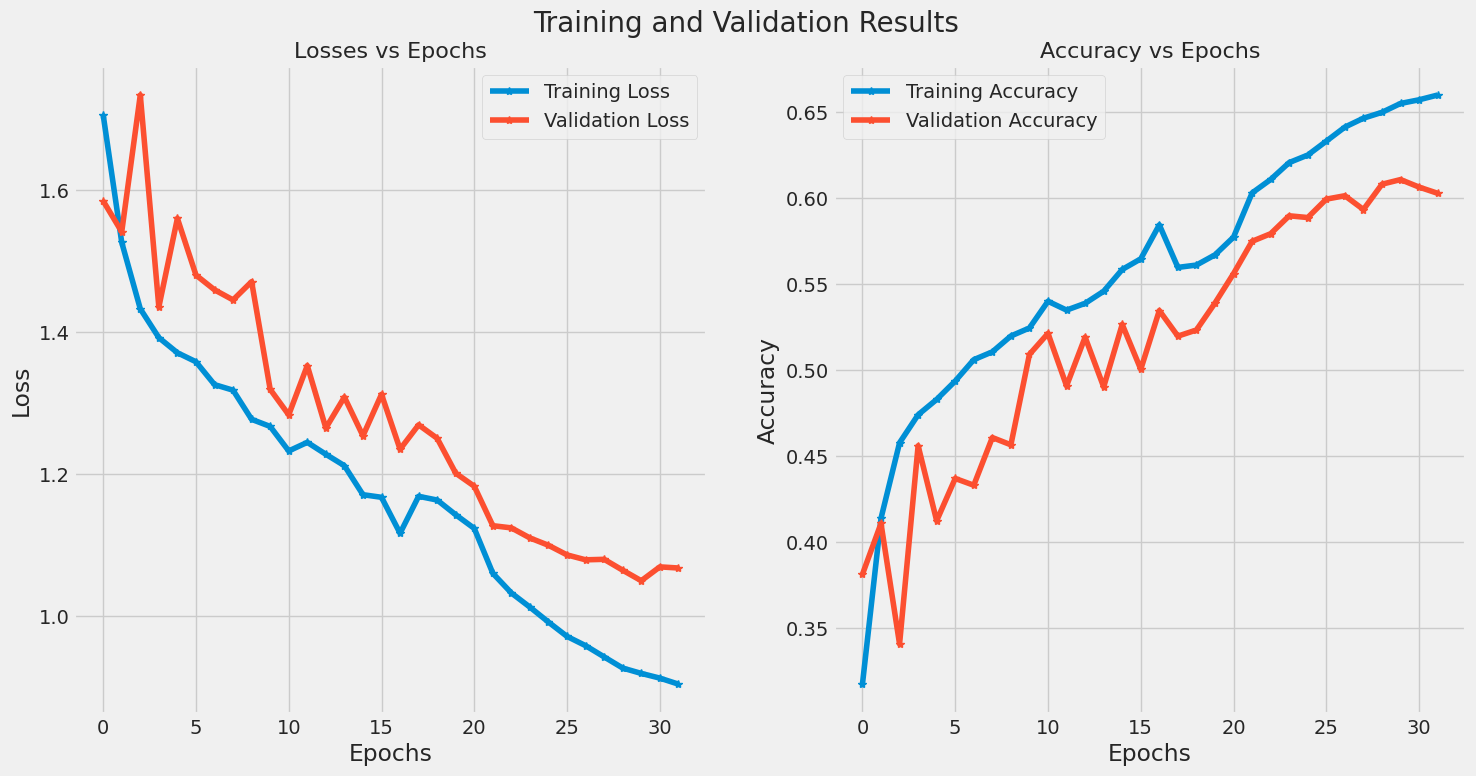

In [11]:
plot_results(history)

##### 

In [12]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_cm = evaluate_model(trained_model, test_loader, criterion, device)
print("-"*45)
print(f"| Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} |")
print("-"*45)

---------------------------------------------
| Test Loss: 0.9767 | Test Accuracy: 0.6383 |
---------------------------------------------


In [13]:
def plot_confusion_matrix(confusion_matrix, title=""):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.6)
    fig.colorbar(im, ax=ax)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(
                x=j, y=i, s=int(confusion_matrix[i, j]), va='center', ha='center')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Labels', fontsize=12)
    plt.title(f'Confusion Matrix {title}', y= 1.08,  fontsize=18)
    plt.show()

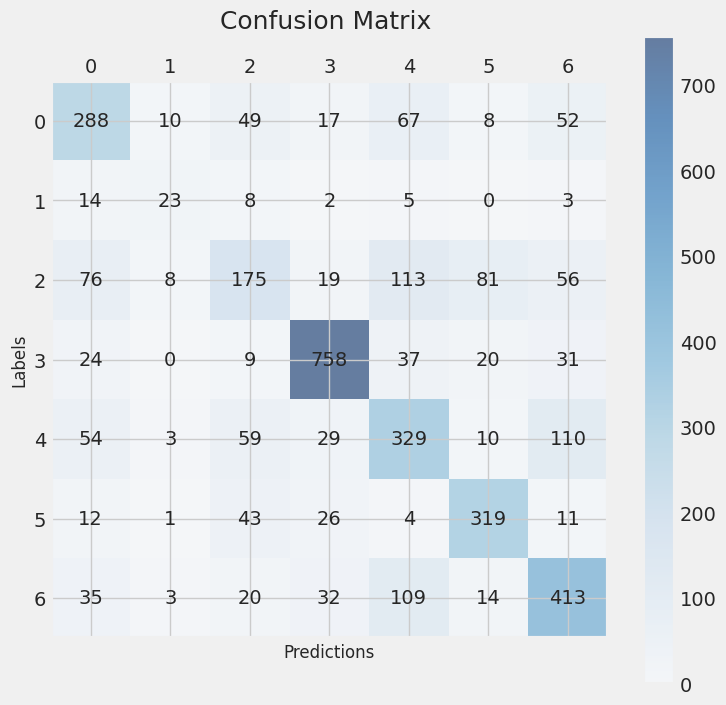

In [14]:
plot_confusion_matrix(test_cm)

In [15]:
def plot_roc(model, dataloader, device, cls=0):
    emotions = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    labels = []
    predicted = []
    model.to(device)
    model.eval()
    for img, lbl in dataloader:
        img, lbl = img.to(device), lbl.to(device)
        output = model(img)
        _, pred = torch.max(output, dim=1)
        lbl = lbl.cpu().numpy()
        lbl = np.where(lbl == cls, 1, 0)
        pred = pred.cpu().numpy()
        labels.extend(lbl)
        predicted.extend(pred)

    fpr, tpr, _ = roc_curve(labels, predicted)
    roc_auc = roc_auc_score(labels, predicted)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k-')
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve: {emotions[cls]} vs Others', fontsize=16)
    plt.legend(loc='best')
    plt.show()

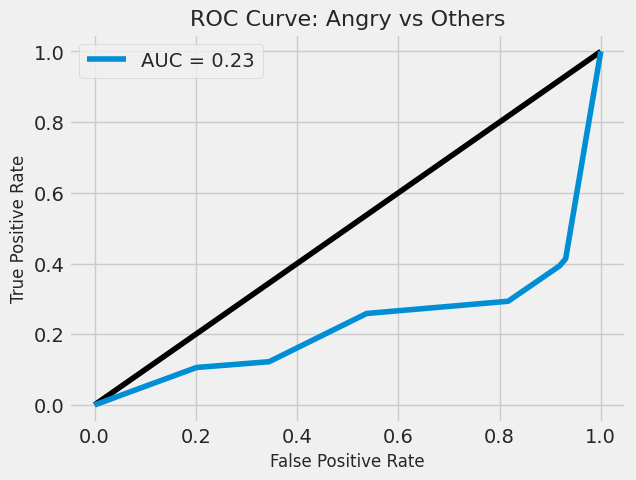

In [16]:
plot_roc(trained_model, test_loader, device)

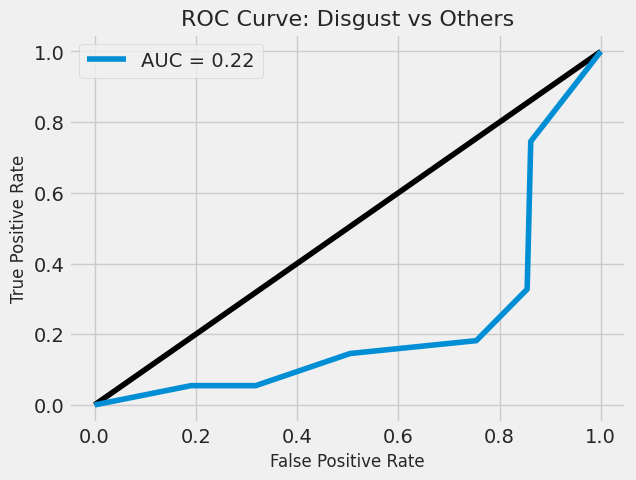

In [17]:
plot_roc(trained_model, test_loader, device, 1)

In [18]:

# predict for a given image


def predict(model, dataloader, device):
    model.to(device)
    model.eval()
    emotions = {
        0: 'Angry',
        1: 'Disgust',
        2: 'Fear',
        3: 'Happy',
        4: 'Sad',
        5: 'Surprise',
        6: 'Neutral'
    }
    # take the first 10 images and plot them with predicted and actual labels
    images = []
    labels = []
    predicted = []
    
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        _, pred = torch.max(output, dim=1)
        for i in range(len(pred)):
            images.append(image[i].cpu().numpy())
            labels.append(label[i].cpu().numpy())
            predicted.append(pred[i].cpu().numpy())
        break
    
    # choose 10 random images
    idx = np.random.choice(len(images), 10)
    images = np.array(images)[idx]
    labels = np.array(labels)[idx]
    predicted = np.array(predicted)[idx]
    
    fig, ax = plt.subplots(2, 5, figsize=(16, 8))
    for i in range(2):
        for j in range(5):
            ax[i, j].imshow(images[i*5+j][0], cmap='gray')
            ax[i, j].set_title(f"Predicted: {emotions[predicted[i*5+j]]}\nLabel: {emotions[labels[i*5+j]]}", fontsize=12)
            ax[i, j].axis('off')
    plt.suptitle('Predictions', y=0.95, fontsize=20)
    plt.show()


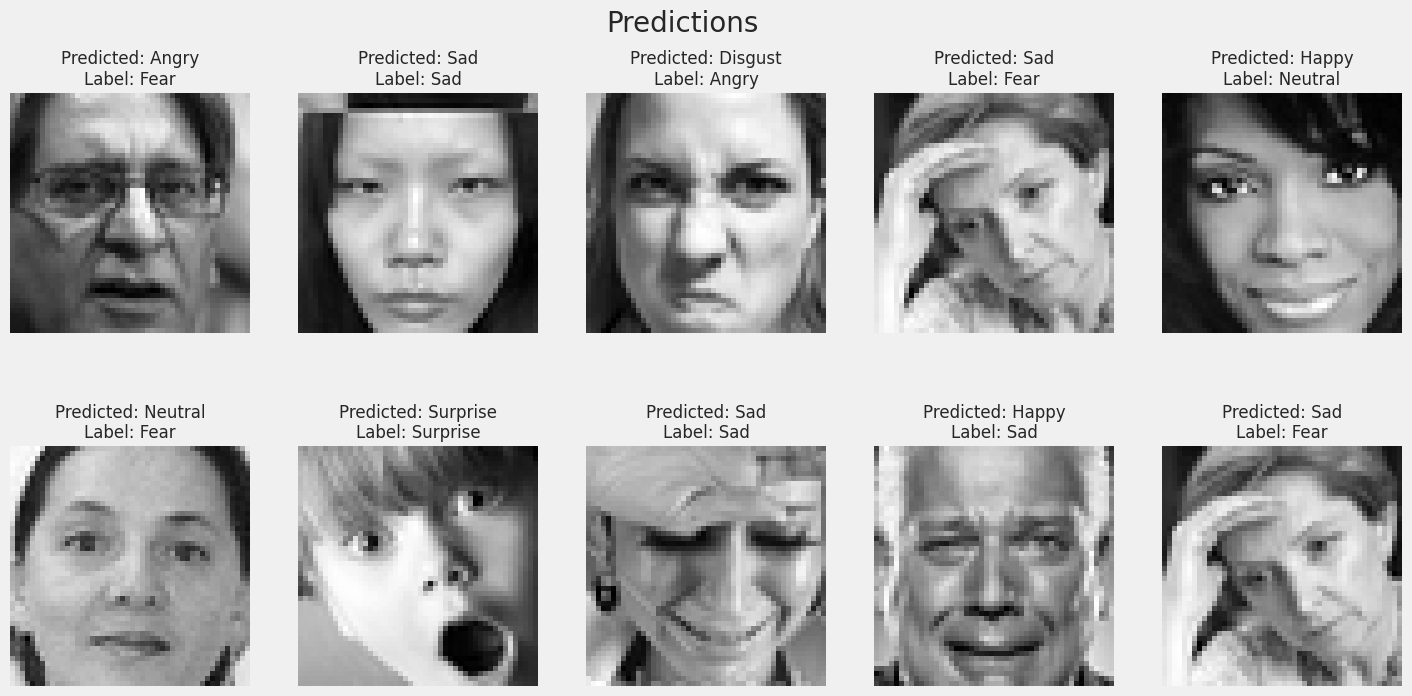

In [19]:
predict(trained_model, test_loader, device)